In [1]:
import gym
import numpy as np
import math
from collections import deque
import time
import matplotlib
import matplotlib.pyplot as plt

class MountaincarQAgent():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.99, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 400
        time_start = time.time()
        
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:                
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    
    def close(self):
        self.env.close()

In [2]:
agent = MountaincarQAgent()
scores, avg_scores = agent.train()

threshold:  -110.0
Episode: 400, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.40, Time: 00:00:13
Episode: 800, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.10, Time: 00:00:27
Episode: 1200, Timesteps:  200, Score: -200.0,  Avg.Score: -199.62, eps-greedy:  0.01, Time: 00:00:41
Episode: 1600, Timesteps:  200, Score: -200.0,  Avg.Score: -196.88, eps-greedy:  0.01, Time: 00:00:55
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.50, eps-greedy:  0.01, Time: 00:01:09
Episode: 2400, Timesteps:  164, Score: -164.0,  Avg.Score: -197.76, eps-greedy:  0.01, Time: 00:01:23
Episode: 2800, Timesteps:  200, Score: -200.0,  Avg.Score: -194.98, eps-greedy:  0.01, Time: 00:01:37
Episode: 3200, Timesteps:  184, Score: -184.0,  Avg.Score: -183.41, eps-greedy:  0.01, Time: 00:01:50
Episode: 3600, Timesteps:  200, Score: -200.0,  Avg.Score: -179.38, eps-greedy:  0.01, Time: 00:02:04
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.5

Episode: 32400, Timesteps:  160, Score: -160.0,  Avg.Score: -145.33, eps-greedy:  0.01, Time: 00:16:00
Episode: 32800, Timesteps:  164, Score: -164.0,  Avg.Score: -142.14, eps-greedy:  0.01, Time: 00:16:10
Episode: 33200, Timesteps:  162, Score: -162.0,  Avg.Score: -143.18, eps-greedy:  0.01, Time: 00:16:20
Episode: 33600, Timesteps:  106, Score: -106.0,  Avg.Score: -146.71, eps-greedy:  0.01, Time: 00:16:30
Episode: 34000, Timesteps:  106, Score: -106.0,  Avg.Score: -143.67, eps-greedy:  0.01, Time: 00:16:40
Episode: 34400, Timesteps:  161, Score: -161.0,  Avg.Score: -140.00, eps-greedy:  0.01, Time: 00:16:50
Episode: 34800, Timesteps:  160, Score: -160.0,  Avg.Score: -139.96, eps-greedy:  0.01, Time: 00:17:00
Episode: 35200, Timesteps:  107, Score: -107.0,  Avg.Score: -142.34, eps-greedy:  0.01, Time: 00:17:10
Episode: 35600, Timesteps:  152, Score: -152.0,  Avg.Score: -143.45, eps-greedy:  0.01, Time: 00:17:20
Episode: 36000, Timesteps:  110, Score: -110.0,  Avg.Score: -144.68, eps-

Episode: 65200, Timesteps:  157, Score: -157.0,  Avg.Score: -152.84, eps-greedy:  0.01, Time: 00:30:12
Episode: 65600, Timesteps:  153, Score: -153.0,  Avg.Score: -151.54, eps-greedy:  0.01, Time: 00:30:23
Episode: 66000, Timesteps:  177, Score: -177.0,  Avg.Score: -149.41, eps-greedy:  0.01, Time: 00:30:33
Episode: 66400, Timesteps:  115, Score: -115.0,  Avg.Score: -160.26, eps-greedy:  0.01, Time: 00:30:44
Episode: 66800, Timesteps:  162, Score: -162.0,  Avg.Score: -164.08, eps-greedy:  0.01, Time: 00:30:55
Episode: 67200, Timesteps:  198, Score: -198.0,  Avg.Score: -173.83, eps-greedy:  0.01, Time: 00:31:07
Episode: 67600, Timesteps:  171, Score: -171.0,  Avg.Score: -157.68, eps-greedy:  0.01, Time: 00:31:18
Episode: 68000, Timesteps:  170, Score: -170.0,  Avg.Score: -159.78, eps-greedy:  0.01, Time: 00:31:30
Episode: 68400, Timesteps:  155, Score: -155.0,  Avg.Score: -151.45, eps-greedy:  0.01, Time: 00:31:40
Episode: 68800, Timesteps:  119, Score: -119.0,  Avg.Score: -161.02, eps-

Episode: 97200, Timesteps:  140, Score: -140.0,  Avg.Score: -140.81, eps-greedy:  0.01, Time: 00:44:29
Episode: 97600, Timesteps:  137, Score: -137.0,  Avg.Score: -139.96, eps-greedy:  0.01, Time: 00:44:38
Episode: 98000, Timesteps:  107, Score: -107.0,  Avg.Score: -139.29, eps-greedy:  0.01, Time: 00:44:48
Episode: 98400, Timesteps:  138, Score: -138.0,  Avg.Score: -136.46, eps-greedy:  0.01, Time: 00:44:58
Episode: 98800, Timesteps:  111, Score: -111.0,  Avg.Score: -138.98, eps-greedy:  0.01, Time: 00:45:08
Episode: 99200, Timesteps:  136, Score: -136.0,  Avg.Score: -135.94, eps-greedy:  0.01, Time: 00:45:17
Episode: 99600, Timesteps:  153, Score: -153.0,  Avg.Score: -137.14, eps-greedy:  0.01, Time: 00:45:27
Episode: 100000, Timesteps:  144, Score: -144.0,  Avg.Score: -138.61, eps-greedy:  0.01, Time: 00:45:37
Episode: 100400, Timesteps:  137, Score: -137.0,  Avg.Score: -137.01, eps-greedy:  0.01, Time: 00:45:46
Episode: 100800, Timesteps:  137, Score: -137.0,  Avg.Score: -139.90, e

Episode: 128800, Timesteps:  152, Score: -152.0,  Avg.Score: -141.05, eps-greedy:  0.01, Time: 00:57:37
Episode: 129200, Timesteps:  146, Score: -146.0,  Avg.Score: -142.53, eps-greedy:  0.01, Time: 00:57:47
Episode: 129600, Timesteps:  112, Score: -112.0,  Avg.Score: -145.48, eps-greedy:  0.01, Time: 00:57:58
Episode: 130000, Timesteps:  144, Score: -144.0,  Avg.Score: -143.62, eps-greedy:  0.01, Time: 00:58:08
Episode: 130400, Timesteps:  147, Score: -147.0,  Avg.Score: -155.13, eps-greedy:  0.01, Time: 00:58:19
Episode: 130800, Timesteps:  159, Score: -159.0,  Avg.Score: -146.77, eps-greedy:  0.01, Time: 00:58:30
Episode: 131200, Timesteps:  166, Score: -166.0,  Avg.Score: -148.43, eps-greedy:  0.01, Time: 00:58:40
Episode: 131600, Timesteps:  169, Score: -169.0,  Avg.Score: -149.13, eps-greedy:  0.01, Time: 00:58:50
Episode: 132000, Timesteps:  113, Score: -113.0,  Avg.Score: -145.37, eps-greedy:  0.01, Time: 00:59:01
Episode: 132400, Timesteps:  153, Score: -153.0,  Avg.Score: -14

Episode: 160400, Timesteps:  157, Score: -157.0,  Avg.Score: -147.46, eps-greedy:  0.01, Time: 01:11:54
Episode: 160800, Timesteps:  161, Score: -161.0,  Avg.Score: -143.60, eps-greedy:  0.01, Time: 01:12:05
Episode: 161200, Timesteps:  154, Score: -154.0,  Avg.Score: -146.72, eps-greedy:  0.01, Time: 01:12:15
Episode: 161600, Timesteps:  144, Score: -144.0,  Avg.Score: -141.53, eps-greedy:  0.01, Time: 01:12:26
Episode: 162000, Timesteps:  157, Score: -157.0,  Avg.Score: -143.78, eps-greedy:  0.01, Time: 01:12:36
Episode: 162400, Timesteps:  119, Score: -119.0,  Avg.Score: -146.46, eps-greedy:  0.01, Time: 01:12:47
Episode: 162800, Timesteps:  158, Score: -158.0,  Avg.Score: -145.23, eps-greedy:  0.01, Time: 01:12:57
Episode: 163200, Timesteps:  119, Score: -119.0,  Avg.Score: -145.66, eps-greedy:  0.01, Time: 01:13:08
Episode: 163600, Timesteps:  148, Score: -148.0,  Avg.Score: -150.80, eps-greedy:  0.01, Time: 01:13:18
Episode: 164000, Timesteps:  120, Score: -120.0,  Avg.Score: -14

Episode: 192000, Timesteps:  165, Score: -165.0,  Avg.Score: -168.01, eps-greedy:  0.01, Time: 01:25:29
Episode: 192400, Timesteps:  147, Score: -147.0,  Avg.Score: -157.38, eps-greedy:  0.01, Time: 01:25:41
Episode: 192800, Timesteps:  149, Score: -149.0,  Avg.Score: -155.98, eps-greedy:  0.01, Time: 01:25:53
Episode: 193200, Timesteps:  151, Score: -151.0,  Avg.Score: -156.69, eps-greedy:  0.01, Time: 01:26:06
Episode: 193600, Timesteps:  163, Score: -163.0,  Avg.Score: -163.91, eps-greedy:  0.01, Time: 01:26:17
Episode: 194000, Timesteps:  182, Score: -182.0,  Avg.Score: -151.92, eps-greedy:  0.01, Time: 01:26:28
Episode: 194400, Timesteps:  146, Score: -146.0,  Avg.Score: -145.61, eps-greedy:  0.01, Time: 01:26:38
Episode: 194800, Timesteps:  150, Score: -150.0,  Avg.Score: -145.35, eps-greedy:  0.01, Time: 01:26:48
Episode: 195200, Timesteps:  153, Score: -153.0,  Avg.Score: -137.59, eps-greedy:  0.01, Time: 01:26:58
Episode: 195600, Timesteps:  115, Score: -115.0,  Avg.Score: -14

Episode: 224000, Timesteps:  148, Score: -148.0,  Avg.Score: -158.64, eps-greedy:  0.01, Time: 01:39:29
Episode: 224400, Timesteps:  143, Score: -143.0,  Avg.Score: -156.15, eps-greedy:  0.01, Time: 01:39:40
Episode: 224800, Timesteps:  183, Score: -183.0,  Avg.Score: -162.00, eps-greedy:  0.01, Time: 01:39:51
Episode: 225200, Timesteps:  165, Score: -165.0,  Avg.Score: -162.44, eps-greedy:  0.01, Time: 01:40:03
Episode: 225600, Timesteps:  147, Score: -147.0,  Avg.Score: -159.45, eps-greedy:  0.01, Time: 01:40:15
Episode: 226000, Timesteps:  180, Score: -180.0,  Avg.Score: -155.34, eps-greedy:  0.01, Time: 01:40:26
Episode: 226400, Timesteps:  141, Score: -141.0,  Avg.Score: -135.42, eps-greedy:  0.01, Time: 01:40:37
Episode: 226800, Timesteps:  155, Score: -155.0,  Avg.Score: -138.15, eps-greedy:  0.01, Time: 01:40:46
Episode: 227200, Timesteps:  162, Score: -162.0,  Avg.Score: -140.93, eps-greedy:  0.01, Time: 01:40:57
Episode: 227600, Timesteps:  110, Score: -110.0,  Avg.Score: -14

Episode: 256000, Timesteps:  158, Score: -158.0,  Avg.Score: -141.56, eps-greedy:  0.01, Time: 01:53:05
Episode: 256400, Timesteps:  138, Score: -138.0,  Avg.Score: -138.82, eps-greedy:  0.01, Time: 01:53:14
Episode: 256800, Timesteps:  108, Score: -108.0,  Avg.Score: -136.70, eps-greedy:  0.01, Time: 01:53:24
Episode: 257200, Timesteps:  200, Score: -200.0,  Avg.Score: -158.31, eps-greedy:  0.01, Time: 01:53:34
Episode: 257600, Timesteps:  140, Score: -140.0,  Avg.Score: -136.73, eps-greedy:  0.01, Time: 01:53:45
Episode: 258000, Timesteps:  109, Score: -109.0,  Avg.Score: -137.11, eps-greedy:  0.01, Time: 01:53:54
Episode: 258400, Timesteps:  139, Score: -139.0,  Avg.Score: -139.84, eps-greedy:  0.01, Time: 01:54:04
Episode: 258800, Timesteps:  156, Score: -156.0,  Avg.Score: -135.58, eps-greedy:  0.01, Time: 01:54:13
Episode: 259200, Timesteps:  154, Score: -154.0,  Avg.Score: -138.33, eps-greedy:  0.01, Time: 01:54:23
Episode: 259600, Timesteps:  149, Score: -149.0,  Avg.Score: -14

Episode: 287600, Timesteps:  167, Score: -167.0,  Avg.Score: -144.05, eps-greedy:  0.01, Time: 02:06:23
Episode: 288000, Timesteps:  158, Score: -158.0,  Avg.Score: -142.68, eps-greedy:  0.01, Time: 02:06:34
Episode: 288400, Timesteps:  107, Score: -107.0,  Avg.Score: -159.29, eps-greedy:  0.01, Time: 02:06:45
Episode: 288800, Timesteps:  146, Score: -146.0,  Avg.Score: -143.07, eps-greedy:  0.01, Time: 02:06:55
Episode: 289200, Timesteps:  148, Score: -148.0,  Avg.Score: -146.47, eps-greedy:  0.01, Time: 02:07:06
Episode: 289600, Timesteps:  166, Score: -166.0,  Avg.Score: -146.70, eps-greedy:  0.01, Time: 02:07:16
Episode: 290000, Timesteps:  160, Score: -160.0,  Avg.Score: -147.12, eps-greedy:  0.01, Time: 02:07:26
Episode: 290400, Timesteps:  167, Score: -167.0,  Avg.Score: -155.37, eps-greedy:  0.01, Time: 02:07:37
Episode: 290800, Timesteps:  160, Score: -160.0,  Avg.Score: -136.96, eps-greedy:  0.01, Time: 02:07:47
Episode: 291200, Timesteps:  167, Score: -167.0,  Avg.Score: -14

Episode: 319200, Timesteps:  175, Score: -175.0,  Avg.Score: -155.87, eps-greedy:  0.01, Time: 02:19:57
Episode: 319600, Timesteps:  194, Score: -194.0,  Avg.Score: -169.26, eps-greedy:  0.01, Time: 02:20:08
Episode: 320000, Timesteps:  200, Score: -200.0,  Avg.Score: -191.72, eps-greedy:  0.01, Time: 02:20:21
Episode: 320400, Timesteps:  150, Score: -150.0,  Avg.Score: -187.79, eps-greedy:  0.01, Time: 02:20:34
Episode: 320800, Timesteps:  193, Score: -193.0,  Avg.Score: -184.12, eps-greedy:  0.01, Time: 02:20:47
Episode: 321200, Timesteps:  184, Score: -184.0,  Avg.Score: -172.09, eps-greedy:  0.01, Time: 02:20:59
Episode: 321600, Timesteps:  151, Score: -151.0,  Avg.Score: -160.50, eps-greedy:  0.01, Time: 02:21:11
Episode: 322000, Timesteps:  170, Score: -170.0,  Avg.Score: -160.25, eps-greedy:  0.01, Time: 02:21:22
Episode: 322400, Timesteps:  200, Score: -200.0,  Avg.Score: -164.91, eps-greedy:  0.01, Time: 02:21:33
Episode: 322800, Timesteps:  145, Score: -145.0,  Avg.Score: -14

Episode: 351200, Timesteps:  141, Score: -141.0,  Avg.Score: -140.44, eps-greedy:  0.01, Time: 02:33:43
Episode: 351600, Timesteps:  142, Score: -142.0,  Avg.Score: -138.65, eps-greedy:  0.01, Time: 02:33:52
Episode: 352000, Timesteps:  156, Score: -156.0,  Avg.Score: -138.57, eps-greedy:  0.01, Time: 02:34:02
Episode: 352400, Timesteps:  141, Score: -141.0,  Avg.Score: -139.69, eps-greedy:  0.01, Time: 02:34:12
Episode: 352800, Timesteps:  140, Score: -140.0,  Avg.Score: -150.21, eps-greedy:  0.01, Time: 02:34:23
Episode: 353200, Timesteps:  110, Score: -110.0,  Avg.Score: -141.07, eps-greedy:  0.01, Time: 02:34:32
Episode: 353600, Timesteps:  153, Score: -153.0,  Avg.Score: -138.09, eps-greedy:  0.01, Time: 02:34:42
Episode: 354000, Timesteps:  148, Score: -148.0,  Avg.Score: -141.25, eps-greedy:  0.01, Time: 02:34:52
Episode: 354400, Timesteps:  142, Score: -142.0,  Avg.Score: -142.67, eps-greedy:  0.01, Time: 02:35:02
Episode: 354800, Timesteps:  159, Score: -159.0,  Avg.Score: -14

Episode: 382800, Timesteps:  140, Score: -140.0,  Avg.Score: -142.06, eps-greedy:  0.01, Time: 02:47:02
Episode: 383200, Timesteps:  156, Score: -156.0,  Avg.Score: -139.82, eps-greedy:  0.01, Time: 02:47:12
Episode: 383600, Timesteps:  161, Score: -161.0,  Avg.Score: -142.80, eps-greedy:  0.01, Time: 02:47:21
Episode: 384000, Timesteps:  141, Score: -141.0,  Avg.Score: -140.65, eps-greedy:  0.01, Time: 02:47:31
Episode: 384400, Timesteps:  108, Score: -108.0,  Avg.Score: -139.05, eps-greedy:  0.01, Time: 02:47:41
Episode: 384800, Timesteps:  146, Score: -146.0,  Avg.Score: -146.87, eps-greedy:  0.01, Time: 02:47:51
Episode: 385200, Timesteps:  139, Score: -139.0,  Avg.Score: -142.72, eps-greedy:  0.01, Time: 02:48:01
Episode: 385600, Timesteps:  189, Score: -189.0,  Avg.Score: -142.03, eps-greedy:  0.01, Time: 02:48:11
Episode: 386000, Timesteps:  140, Score: -140.0,  Avg.Score: -139.75, eps-greedy:  0.01, Time: 02:48:21
Episode: 386400, Timesteps:  188, Score: -188.0,  Avg.Score: -14

Episode: 415200, Timesteps:  200, Score: -200.0,  Avg.Score: -194.25, eps-greedy:  0.01, Time: 03:00:48
Episode: 415600, Timesteps:  192, Score: -192.0,  Avg.Score: -197.01, eps-greedy:  0.01, Time: 03:01:02
Episode: 416000, Timesteps:  190, Score: -190.0,  Avg.Score: -194.66, eps-greedy:  0.01, Time: 03:01:16
Episode: 416400, Timesteps:  191, Score: -191.0,  Avg.Score: -194.87, eps-greedy:  0.01, Time: 03:01:29
Episode: 416800, Timesteps:  200, Score: -200.0,  Avg.Score: -196.60, eps-greedy:  0.01, Time: 03:01:43
Episode: 417200, Timesteps:  190, Score: -190.0,  Avg.Score: -174.11, eps-greedy:  0.01, Time: 03:01:56
Episode: 417600, Timesteps:  153, Score: -153.0,  Avg.Score: -171.44, eps-greedy:  0.01, Time: 03:02:08
Episode: 418000, Timesteps:  151, Score: -151.0,  Avg.Score: -152.72, eps-greedy:  0.01, Time: 03:02:19
Episode: 418400, Timesteps:  151, Score: -151.0,  Avg.Score: -149.82, eps-greedy:  0.01, Time: 03:02:29
Episode: 418800, Timesteps:  162, Score: -162.0,  Avg.Score: -14

Episode: 446800, Timesteps:  110, Score: -110.0,  Avg.Score: -136.95, eps-greedy:  0.01, Time: 03:14:52
Episode: 447200, Timesteps:  181, Score: -181.0,  Avg.Score: -128.39, eps-greedy:  0.01, Time: 03:15:01
Episode: 447600, Timesteps:  171, Score: -171.0,  Avg.Score: -132.91, eps-greedy:  0.01, Time: 03:15:10
Episode: 448000, Timesteps:  172, Score: -172.0,  Avg.Score: -150.61, eps-greedy:  0.01, Time: 03:15:20
Episode: 448400, Timesteps:  85, Score: -85.0,  Avg.Score: -128.99, eps-greedy:  0.01, Time: 03:15:29
Episode: 448800, Timesteps:  107, Score: -107.0,  Avg.Score: -127.15, eps-greedy:  0.01, Time: 03:15:38
Episode: 449200, Timesteps:  162, Score: -162.0,  Avg.Score: -129.41, eps-greedy:  0.01, Time: 03:15:47
Episode: 449600, Timesteps:  149, Score: -149.0,  Avg.Score: -147.68, eps-greedy:  0.01, Time: 03:15:57
Episode: 450000, Timesteps:  150, Score: -150.0,  Avg.Score: -148.18, eps-greedy:  0.01, Time: 03:16:07
Episode: 450400, Timesteps:  156, Score: -156.0,  Avg.Score: -160.

Episode: 478800, Timesteps:  153, Score: -153.0,  Avg.Score: -167.41, eps-greedy:  0.01, Time: 03:28:32
Episode: 479200, Timesteps:  138, Score: -138.0,  Avg.Score: -139.13, eps-greedy:  0.01, Time: 03:28:42
Episode: 479600, Timesteps:  180, Score: -180.0,  Avg.Score: -151.66, eps-greedy:  0.01, Time: 03:28:52
Episode: 480000, Timesteps:  156, Score: -156.0,  Avg.Score: -155.10, eps-greedy:  0.01, Time: 03:29:03
Episode: 480400, Timesteps:  149, Score: -149.0,  Avg.Score: -139.86, eps-greedy:  0.01, Time: 03:29:13
Episode: 480800, Timesteps:  152, Score: -152.0,  Avg.Score: -146.25, eps-greedy:  0.01, Time: 03:29:23
Episode: 481200, Timesteps:  187, Score: -187.0,  Avg.Score: -160.33, eps-greedy:  0.01, Time: 03:29:33
Episode: 481600, Timesteps:  161, Score: -161.0,  Avg.Score: -158.97, eps-greedy:  0.01, Time: 03:29:45
Episode: 482000, Timesteps:  147, Score: -147.0,  Avg.Score: -141.25, eps-greedy:  0.01, Time: 03:29:55
Episode: 482400, Timesteps:  146, Score: -146.0,  Avg.Score: -13

length of scores:  500000 , len of avg_scores:  500000


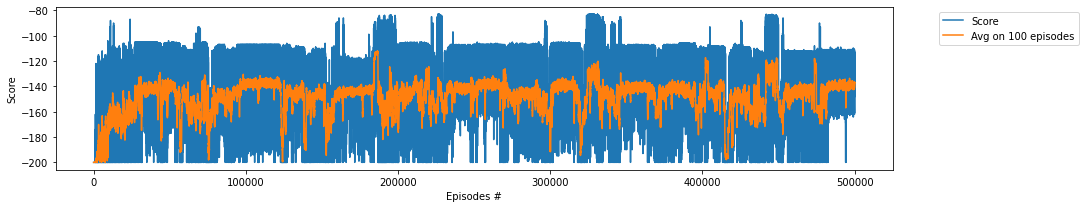

In [3]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
agent.close()